In [4]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
import xmlrpc.client
import pandas as pd
import os

class Params:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    
    @property
    def F_o(self):
        return self.Omega_o / (2 * np.pi)

    @property
    def Omega_o(self):
        return 1 / np.sqrt(self.L_r * self.C_r)
    
    @property
    def Omega_s(self):
        return 2 * np.pi * self.F_s

    @property
    def n(self):
        return self.n_pri / self.n_sec
        
    @property
    def L_n(self):
        return self.L_m / self.L_r

    @property
    def Omega_n(self):
        return self.Omega_s / self.Omega_o

    @property
    def K_d(self):
        """ (7) """
        return 2 / np.pi * self.L_n / (np.sin(self.Omega_n * np.pi / 2))
        """ 2 """
        return -4 * self.V_g / np.pi * 1/(self.Omega_o * self.L_n)

def get_tfs(p: Params):

    L_r = p.L_r
    L_m = p.L_m
    C_r = p.C_r
    C_f = p.C_f
    n = p.n
    R_L = p.R_L
    V_g = 2 * p.V_g # account for full-bridge inverter in PLECS model
    L_n = p.L_n
    F_s = p.F_s
    F_o = p.F_o
    Omega_s = p.Omega_s
    Omega_o = p.Omega_o

    Omega_n = p.Omega_n

    X_eq = Omega_s * L_r - 1 / (Omega_s * C_r) # equivalent reactance (Ohms)
    R_eq = 8 / np.pi**2 * n**2 * R_L # equivalent resistance (Ohms)
    Q = np.sqrt(L_r / C_r) / (n**2 * R_L)

    s = ctrl.TransferFunction([1, 0], [1])

    """ For F_s >= F_o: (14) """
    if F_s >= F_o:
        G_DC = (
            # leading terms
            (V_g / (2 * n)) * (L_n / (Omega_o * Omega_n)) *
            ( # numerator 
                (1/Omega_n**2 - Omega_n**2) * \
                (np.pi**2/8 * Q * L_n)**2 - \
                (L_n + 1 - 1/Omega_n**2) * \
                (2 / Omega_n**2)
            ) / 
            ( # denominator
                np.sqrt(
                    (L_n + 1 - 1 / Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                )
            ) ** 3
        )

        L_e = (1 + Omega_o**2 / Omega_s**2) * L_r

        T_omega_s_to_v_o = G_DC * (X_eq**2 + R_eq**2) / (
            (s**2 * L_e**2 + s*L_e*R_eq + X_eq**2) * (1 + R_L*C_f*s) + \
            R_eq * (s*L_e + R_eq)
        )

    elif F_s < F_o:
        G_DC = (V_g / (2 * n) * L_n / Omega_o *
            ( # numerator 
                (
                    (1/Omega_n**2 - Omega_n**2) * \
                    (np.pi**2/8 * Q * L_n)**2 - \
                    (L_n + 1 - 1/Omega_n**2) * \
                    (2 / Omega_n**2)
                ) * \
                (1 / Omega_n) * \
                (1 / np.sin(np.pi / 2 * Omega_n)) + \
                (
                    (L_n + 1 - 1/Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                ) * \
                (-np.pi/2 * np.cos(np.pi/2 * Omega_n) / np.sin(np.pi/2 * Omega_n))
            ) /
            ( # denominator
                np.sqrt(
                    (L_n + 1 - 1 / Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                )
            ) ** 3
        )

        L_e = L_r * (1 + 1 / Omega_n**2) + L_m * (1 - Omega_n)
        omega_p = np.sqrt(1/(L_e * np.pi**2/(8*n**2) * C_f))
        Q_p = 8 * n / np.pi**2 * R_L * np.sqrt(C_f / L_e)
        # L_e = (1 + Omega_o**2 / Omega_s**2) * L_r + (1 - Omega_s / Omega_o) * L_m
        T_omega_s_to_v_o = G_DC * 1 / (1 + s/(Q_p * omega_p) + (s**2 / omega_p**2))

    else:
        raise ValueError("Invalid switching frequency")

    return T_omega_s_to_v_o




In [3]:
def run_plecs(p: Params):
    s = xmlrpc.client.Server('http://localhost:1080/RPC2')
    sim_name = "llc"
    sim_path = os.path.join(os.getcwd(), f'{sim_name}.plecs')
    s.plecs.load(sim_path)
    # get p.__dict__ as well as all properties
    ModelVars = {**p.__dict__, **{k: getattr(p, k) for k in dir(p) if not k.startswith("__")}}
    # coerce to float
    ModelVars = {k: float(v) for k, v in ModelVars.items()}

    result = s.plecs.analyze(sim_name, 'Multitone Analysis', 
    {"ModelVars": ModelVars, "SolverOpts": {}})
    df = pd.DataFrame({
        "F": result["F"],
        "Gr": result["Gr"][0],
        "Gi": result["Gi"][0],
    })
    df["magnitude"] = 20 * np.log10(np.sqrt(df["Gr"]**2 + df["Gi"]**2))
    # df["phase"] = np.arctan2(df["Gi"], df["Gr"]) * (180 / np.pi)
    # unwrap phase
    df["phase"] = np.unwrap(np.arctan2(df["Gi"], df["Gr"])) * (180 / np.pi)
    return df

In [28]:
p = Params(**{
    "L_r": 2e-6,  # resonant inductance (H)
    "L_m": 10e-6,  # magnetizing inductance (H)
    "C_r": 5.6e-9,  # resonant capacitance (F)
    "C_f": 100e-6,   # filter capacitance (F)
    "n_pri": 6,     # number of primary turns
    "n_sec": 1,     # number of secondary turns
    "R_L": 1.53,       # load resistance (Ohms) 
    "V_g": 270,      # input voltage (V)
    "F_s": 1.5e6,   # switching frequency (Hz)
    "C_v_init": 48,
})

op_points = [
    {"R_L": 1.53, "freq_rel": 1.0},
]

dfs = []
for op_point in op_points:
    p.R_L = op_point["R_L"]
    p.F_s = op_point["freq_rel"] * p.F_o
    print(f"F_s: {p.F_s}")
    df = run_plecs(p)
    dfs.append(df)


F_s: 1503872.8548135445


<TransferFunction>: sys[684]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                          -1.551e+12
---------------------------------------------------------------
(s + (3268-2.701e+05j)) (s + (3268+2.701e+05j)) (s + 1.116e+07)



C:\Users\nickk\AppData\Local\Temp\ipykernel_13604\2403523348.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(df["F"] , df["magnitude"], 'r--', label=f"PLECS: {label}", color="magenta", linewidth=2.5)
C:\Users\nickk\AppData\Local\Temp\ipykernel_13604\2403523348.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax[1].plot(df["F"] , df["phase"], 'r--', label=f"PLECS: {label}", color="magenta", linewidth=2.5)


Text(0.5, 0.98, '')

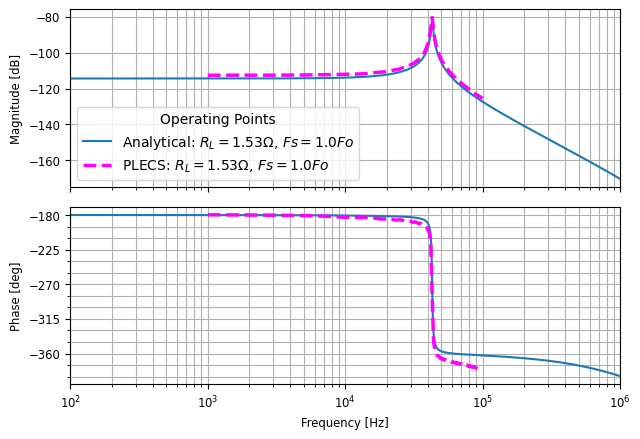

In [38]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, op_point in enumerate(op_points):
    p.R_L = op_point["R_L"]
    p.F_s = op_point["freq_rel"] * p.F_o
    
    T_omega_s_to_v_o = get_tfs(p)
    ratio = p.F_s / p.F_o
    # print the order of the transfer function
    T_omega_s_to_v_o.display_format = "zpk"
    print(T_omega_s_to_v_o)
    label = f"$R_L = {p.R_L:.2f} \Omega$, $Fs={ratio}Fo$"
    ctrl.bode(T_omega_s_to_v_o, dB=True, Hz=True, 
            omega_limits=(100*2*np.pi, 1e6*2*np.pi), label=f"Analytical: {label}", color=colors[i])
    ax = plt.gcf().get_axes()
    df = dfs[i]
    ax[0].plot(df["F"] , df["magnitude"], 'r--', label=f"PLECS: {label}", color="magenta", linewidth=2.5)
    ax[1].plot(df["F"] , df["phase"], 'r--', label=f"PLECS: {label}", color="magenta", linewidth=2.5)

# set the x-limits
plt.xlim(1e2, 1e6)
# get both axes of the 2,1 subplots
ax = plt.gcf().get_axes()
# make the fontsize smaller than 'small'
ax[0].legend(loc='lower left', title='Operating Points')
fig = plt.gcf()
fig.suptitle("")



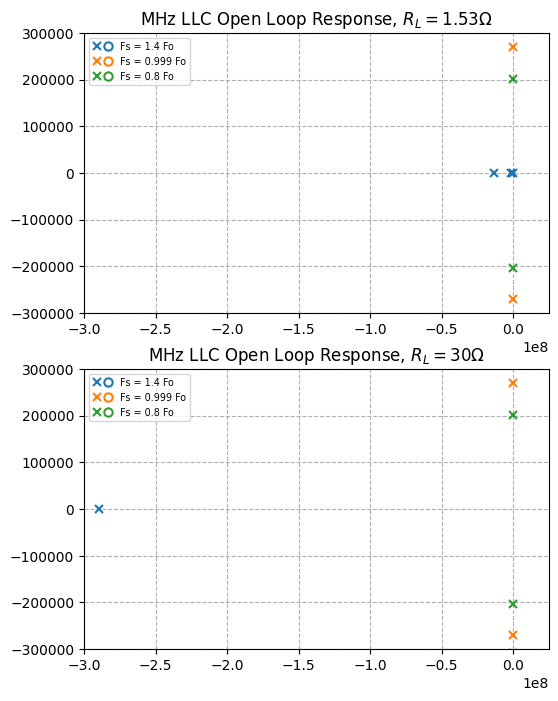

In [8]:

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
for j, R_L in enumerate([1.53, 30]):
    p.R_L = R_L
    for i, F_s in enumerate(np.array([1.4, 0.999, 0.8]) * p.F_o):
        p.F_s = float(F_s)
        T_omega_s_to_v_o = get_tfs(p)
        ratio = p.F_s / p.F_o
        # print the order of the transfer function
        T_omega_s_to_v_o.display_format = "zpk"
        # plot the pole zero map
        ctrl.pzmap(T_omega_s_to_v_o, title=f"Fs = {ratio} Fo", ax=ax[j], label=f"Fs = {ratio} Fo", legend_loc='upper left')
    
    ax[j].grid(which='both', linestyle='--')
    ax[j].set_title(r"MHz LLC Open Loop Response, $R_L=$" + str(R_L) + r"$\Omega$")
    ax[j].set_xlim(-3e8, 0.25e8)
    ax[j].set_ylim(-3e5, 3e5)

In [9]:
p = Params(**{
    "L_r": 2e-6,  # resonant inductance (H)
    "L_m": 10e-6,  # magnetizing inductance (H)
    "C_r": 5.6e-9,  # resonant capacitance (F)
    "C_f": 100e-6,   # filter capacitance (F)
    "n_pri": 6,     # number of primary turns
    "n_sec": 1,     # number of secondary turns
    "R_L": 1.53,       # load resistance (Ohms) 
    "V_g": 270,      # input voltage (V)
    "F_s": 1.0e6,   # switching frequency (Hz)
    "C_v_init": 48,
})
Gp = get_tfs(p)
Gp.display_format = "zpk"
print(Gp)

<TransferFunction>: sys[254]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                  -1.532e+05
-----------------------------------------------
(s + (3630-1.719e+05j)) (s + (3630+1.719e+05j))



Type 2 K-Factor

In [23]:
# Inputs
f_c = 1e3
PM_desired = 60

omega_c = 2 * np.pi * f_c

# get the gain and unwrapped phase at the crossover frequency
mag_sys = np.abs(Gp(1j * omega_c))
phi_sys_deg = (np.angle(Gp(1j * omega_c))  - 2 * np.pi) * 180 / np.pi
print(f"mag_sys: {mag_sys}")
print(f"phi_sys_deg: {phi_sys_deg}")


# phi_sys = np.angle(Gp(1j * omega_c)) * 180 / np.pi
# print(f"phi_sys: {phi_sys} deg")
phi_boost = PM_desired - phi_sys_deg - 90
print(f"phi_boost: {phi_boost}")

# mag_sys_db = 20 * np.log10(mag_sys)



mag_sys: 5.191036845388165e-06
phi_sys_deg: -180.0885495473414
phi_boost: 150.0885495473414


In [ ]:

print(f"Kc: {Kc}")
Gc = ctrl.TransferFunction([-Kc], [1, 0])
print(Gc)

Gcl = Gc * Gp / (1 + Gc * Gp)

plt.figure()
t, yout = ctrl.step_response(Gcl, T=0.01)
plt.plot(t, yout)
plt.title("Closed Loop Step Response")
plt.show()

# closed loop frequency response
plt.figure()
ctrl.bode(Gcl, dB=True, Hz=True, omega_limits=(100*2*np.pi, 1e6*2*np.pi))
plt.suptitle("Closed Loop Frequency Response")
plt.show()

magnitude: -105.69909563247501 dB
Kc: 968778823.4149315
magnitude: -105.69491777074907 dB
Kc: 1210391198.198046
magnitude: -105.66002402708399 dB
Kc: 2411076917.705485


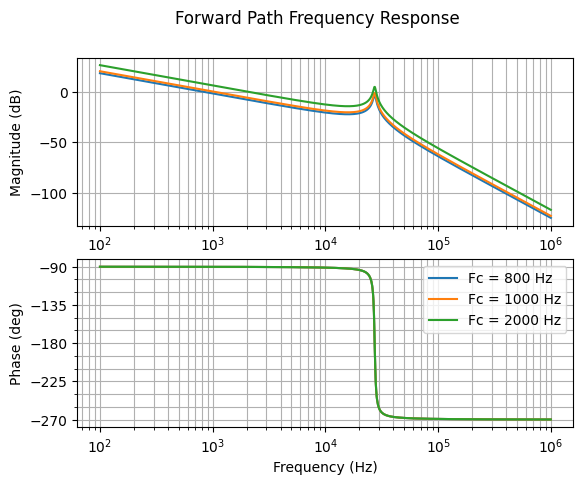

In [48]:

plt.figure()
for f_c in [800, 1000, 2000]:
    omega_c = 2 * np.pi * f_c
    mag = np.abs(Gp(1j * omega_c))
    mag_db = 20 * np.log10(mag)
    print(f"magnitude: {mag_db} dB")
    Kc = omega_c / mag
    print(f"Kc: {Kc}")
    Gc = ctrl.TransferFunction([-Kc], [1, 0])
    Gol = Gp * Gc
    ctrl.bode(Gol, dB=True, Hz=True, omega_limits=(100*2*np.pi, 1e6*2*np.pi), label=f"Fc = {f_c} Hz")
plt.legend()
plt.suptitle("Forward Path Frequency Response")
plt.show()

In [ ]:
f_c = 800
omega_c = 2 * np.pi * f_c
# get the magnitude of Gp at f_c
mag = np.abs(Gp(1j * omega_c))
mag_db = 20 * np.log10(mag)
print(f"magnitude: {mag_db} dB")
Kc = omega_c / mag
print(f"Kc: {Kc}")
Gc = ctrl.TransferFunction([-Kc], [1, 0])
print(Gc)

Gcl = Gc * Gp / (1 + Gc * Gp)

plt.figure()
t, yout = ctrl.step_response(Gcl, T=0.01)
plt.plot(t, yout)
plt.title("Closed Loop Step Response")
plt.show()

# closed loop frequency response
plt.figure()
ctrl.bode(Gcl, dB=True, Hz=True, omega_limits=(100*2*np.pi, 1e6*2*np.pi))
plt.suptitle("Closed Loop Frequency Response")
plt.show()

In [9]:
df.to_csv("llc_plecs.csv", index=False)

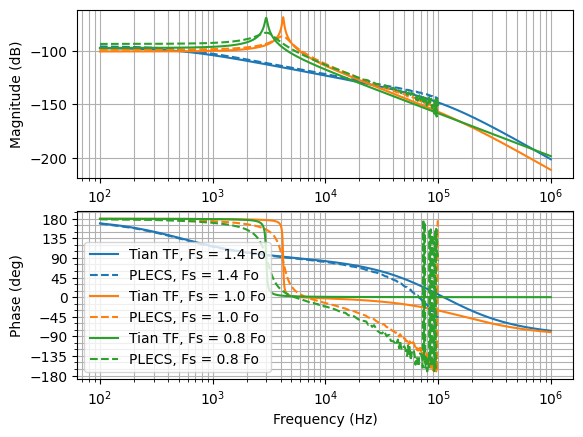

In [26]:

plt.figure()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, F_s in enumerate(np.array([1.4, 1.0, 0.8]) * p.F_o):
    p.F_s = float(F_s)
    T_omega_s_to_v_o = get_tfs(p)
    ratio = p.F_s / p.F_o
    ctrl.bode(T_omega_s_to_v_o, dB=True, Hz=True, initial_phase=180,
            omega_limits=(100*2*np.pi, 1e6*2*np.pi), label=f"Tian TF, Fs = {ratio} Fo",
            color=colors[i])

    ax = plt.gcf().get_axes()
    df = dfs[F_s]
    ax[0].plot(df['F'], df['magnitude'], label=f"PLECS, Fs = {ratio} Fo", color=colors[i], linestyle='--')
    ax[1].plot(df['F'], df['phase'], label=f"PLECS, Fs = {ratio} Fo", color=colors[i], linestyle='--')

plt.legend()
plt.show()
